In [ ]:
import numpy as np
from sklearn.linear_model import SGDRegressor
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
class ContinuousMDP:
    def __init__(self, gamma=0.3):
        """
        Initialize the Continuous MDP.

        Parameters:
        - gamma: Discount factor for the MDP.
        """
        self.gamma = gamma

    def transition(self, s, a):
        """
        Sample the next state given current state s and action a.

        Parameters:
        - s: Current state (float).
        - a: Action taken (float).

        Returns:
        - s_next: Next state (float), sampled from N(s + a, sigma^2).
        """
        mean = s + a
        s_next = np.random.normal(loc=mean, scale=0.5)
        return s_next

    def transition_prob(self, transitions):
        probabilities = []
        for transition in transitions:
            s = transition[0]
            a = transition[1]
            s_next = transition[3]
            mean = s + a
            std = 0.5
            p = norm.pdf(s_next, loc=mean, scale=std)
            probabilities.append(p)
        return probabilities

    def reward(self, s, a):
        """
        Compute the reward for state s and action a.

        Parameters:
        - s: Current state (float).
        - a: Action taken (float).

        Returns:
        - r: Reward (float), computed as - (s + a)^2.
        """
        r = - s ** 2
        return r

    def behavior_policy(self, s):
        """
        Sample an action from the behavior policy given state s.

        Parameters:
        - s: Current state (float).

        Returns:
        - a: Action (float).
        """
        a = np.random.normal(loc=0, scale=0.5)
        return a

    def evaluation_policy(self, s):
        """
        Sample an action from the evaluation policy given state s.

        Parameters:
        - s: Current state (float).

        Returns:
        - a: Action (float).
        """
        a = np.random.normal(loc=-1.0, scale=0.5)
        return a

    def evaluation_policy_exp_a(self, s):
        return -1.0

    def evaluation_policy_exp_a2(self, s):
        return 1.25

    def generate_trajectories(self, policy_function, num_trajectories, trajectory_length, s0=0.0):
        """
        Generate multiple trajectories using the specified policy.

        Parameters:
        - policy_function: Function that takes state s and returns action a.
        - num_trajectories: Number of trajectories to generate (int).
        - trajectory_length: Length of each trajectory (int).
        - s0: Initial state (float). If None, starts from zero.

        Returns:
        - trajectories: List of trajectories, each trajectory is a list of tuples:
                        (state, action, reward, next_state)
        """
        trajectories = []
        for _ in range(num_trajectories):
            trajectory = []
            s = s0
            for _ in range(trajectory_length):
                a = policy_function(s)
                s_next = self.transition(s, a)
                r = self.reward(s, a)
                trajectory.append((s, a, r, s_next))
                s = s_next
            trajectories.append(trajectory)
        return trajectories

    def get_discounted_return(self, rewards):
        """
        Compute the discounted return for a list of rewards.

        Parameters:
        - rewards: List of rewards (float).

        Returns:
        - G: Discounted return (float).
        """
        G = 0.0
        for t, r in enumerate(rewards):
            G += (self.gamma ** t) * r
        return G

In [ ]:
# Initialize the MDP
mdp = ContinuousMDP(gamma=0.3)

In [ ]:
# Define the number of trajectories and their length
num_trajectories = 20000
trajectory_length = 25

# Generate trajectories using the evaluation policy
trajectories_e = mdp.generate_trajectories(
    policy_function=mdp.evaluation_policy,
    num_trajectories=num_trajectories,
    trajectory_length=trajectory_length,
    s0=0
)

trajectory_rewards = []

for traj in trajectories_e:
    rewards = [r for (_, _, r, _) in traj]
    G = mdp.get_discounted_return(rewards)
    trajectory_rewards.append(G)

print(np.mean(trajectory_rewards))

-1.4546462169617727


In [ ]:
s = 0

true_q = -1 * s**2 - np.sum([mdp.gamma**i * ((s - i)**2 + 0.5*i) for i in range(1,51)], axis=0)
true_q

-1.4431486880466469

In [ ]:
# Feature representation
def phi(s, a):
    """
    Feature mapping for state-action pairs.
    For linear function approximation, we can use polynomial features.
    Here, we'll use a simple polynomial basis up to degree 2.
    """
    # Include bias term
    features = np.array([
        1.0,          # Bias term
        s,            # State
        a,            # Action
        s * a,        # Interaction term
        s ** 2,       # State squared
        a ** 2        # Action squared
    ])
    return features

In [ ]:
# Estimate the value of the evaluation policy
def estimate_policy_value(mdp, theta, s0=0.0):
    # TODO for education experiment: expectation over distribution of starting states
    """
    Estimate the value of the evaluation policy using the learned Q-function.

    Parameters:
    - mdp: Instance of the MDP.
    - theta: Parameters of the Q-function approximator.

    Returns:
    - estimated_value: Average estimated value of the evaluation policy.
    """

    exp_phi_sa = np.array([
        1.0,
        s0,
        mdp.evaluation_policy_exp_a(s0),            # E(a)
        s0 * mdp.evaluation_policy_exp_a(s0),
        s0 ** 2,
        mdp.evaluation_policy_exp_a2(s0)            # E(a^2)
    ])

    return exp_phi_sa.dot(theta)

In [ ]:
# Fitted Q Evaluation
def run_fqe(mdp, transitions, num_iterations=20, break_at_converge=True):
    """
    Perform Fitted Q Evaluation (FQE) using linear function approximation.

    Parameters:
    - mdp: Instance of the MDP.
    - data: List of trajectories collected under the behavior policy.
    - num_iterations: Number of iterations to run FQE.

    Returns:
    - theta: Learned parameters for the Q-function approximator.
    """
    # Initialize parameters theta for linear function approximation
    n_features = len(phi(0.0, 0.0))
    theta = np.zeros(n_features)
    theta_history = []

    # Convert transitions to arrays for efficient processing
    states = np.array([t[0] for t in transitions])
    actions = np.array([t[1] for t in transitions])
    rewards = np.array([t[2] for t in transitions])
    next_states = np.array([t[3] for t in transitions])

    # Precompute features for current state-action pairs
    phi_sa = np.array([phi(s, a) for s, a in zip(states, actions)])

    # FQE Iterations
    for iteration in range(num_iterations):
        # Compute targets using the previous estimate of theta
        # For the first iteration, theta is zero, so Q-values are zero
        q_next = [estimate_policy_value(mdp, theta, s0=s_next) for s_next in next_states]
        q_next = np.array(q_next)

        # Compute target values using the Bellman equation
        targets = rewards + mdp.gamma * q_next

        # Solve for theta using least squares regression
        # Minimize || phi_sa @ theta - targets ||^2
        theta_new, residuals, rank, s = np.linalg.lstsq(phi_sa, targets, rcond=None)
        theta_history.append(theta_new)

        # Check convergence
        if break_at_converge:
          theta_change = np.linalg.norm(theta_new - theta)
          if theta_change < 1e-6:
              break

        theta = theta_new

    return theta_history

In [ ]:
def run_fqe_with_influences(mdp, transitions):
    n_features = len(phi(0.0, 0.0))

    # Convert transitions to arrays for efficient processing
    states = np.array([t[0] for t in transitions])
    actions = np.array([t[1] for t in transitions])
    rewards = np.array([t[2] for t in transitions])
    next_states = np.array([t[3] for t in transitions])

    # Precompute features for current state-action pairs
    phi_sa = np.array([phi(s, a) for s, a in zip(states, actions)])
    phi_s_next = np.array([phi(s_next, mdp.evaluation_policy_exp_a(s_next)) for s_next in next_states])

    theta = np.linalg.inv((phi_sa.T @ phi_sa - mdp.gamma * phi_sa.T @ phi_s_next)) @ phi_sa.T @ rewards
    C_inv = np.linalg.inv((phi_sa.T @ phi_sa - mdp.gamma * phi_sa.T @ phi_s_next))

    rewards = np.reshape(rewards, (len(rewards), 1))

    influences = []
    for trans_j in transitions:
      phi_j = np.reshape(phi(trans_j[0], trans_j[1]), (n_features, 1))
      phi_pi_j = np.reshape(phi(trans_j[3], mdp.evaluation_policy_exp_a(trans_j[3])), (n_features, 1))

      B_j = C_inv + ((C_inv @ phi_j @ phi_j.T @ C_inv) / (1 - phi_j.T @ C_inv @ phi_j))

      C_j_inv = B_j - (mdp.gamma * B_j @ phi_j @ phi_pi_j.T @ B_j / (1 + mdp.gamma * phi_pi_j.T @ B_j @ phi_j))
      theta_j = C_j_inv @ (phi_sa.T @ rewards - trans_j[2] * phi_j)
      theta_j = np.reshape(theta_j, (n_features, ))

      influences.append(estimate_policy_value(mdp, theta_j) - estimate_policy_value(mdp, theta))

    return theta, influences

In [ ]:
# Generate data from the behavior policy
num_trajectories = 500
trajectory_length = 20
data = mdp.generate_trajectories(
    policy_function=mdp.behavior_policy,
    num_trajectories=num_trajectories,
    trajectory_length=trajectory_length,
)

# Flatten trajectories into transitions
transitions = [t for traj in data for t in traj]

transition_prob = mdp.transition_prob(transitions)

Running Fitted Q Evaluation (FQE) with 500 trajectories...


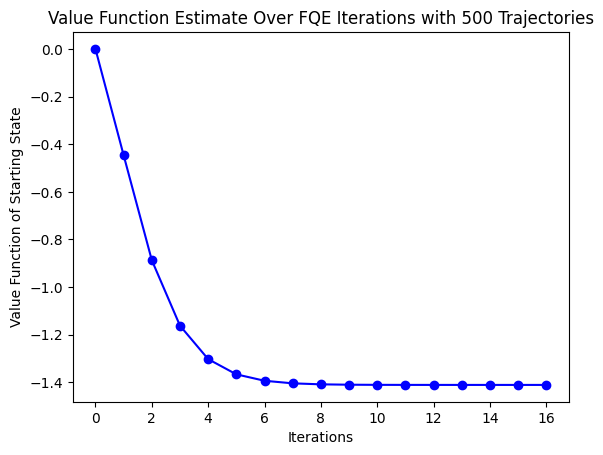

In [ ]:
# Run Fitted Q Evaluation
print("Running Fitted Q Evaluation (FQE) with 500 trajectories...")
theta_history = run_fqe(mdp, transitions)

estimated_values = [estimate_policy_value(mdp, theta) for theta in theta_history]

# Plot the mean
plt.plot(range(len(theta_history)), estimated_values, marker='o', linestyle='-', color='b')
plt.xlabel('Iterations')
plt.ylabel('Value Function of Starting State')
plt.title('Value Function Estimate Over FQE Iterations with 500 Trajectories')

# Display the plot
plt.show()


In [ ]:
# Generate data from the behavior policy
num_trajectories = 20
trajectory_length = 20
data = mdp.generate_trajectories(
    policy_function=mdp.behavior_policy,
    num_trajectories=num_trajectories,
    trajectory_length=trajectory_length,
)

# Flatten trajectories into transitions
transitions = [t for traj in data for t in traj]

transition_prob = mdp.transition_prob(transitions)

Running Fitted Q Evaluation (FQE) with 500 trajectories...


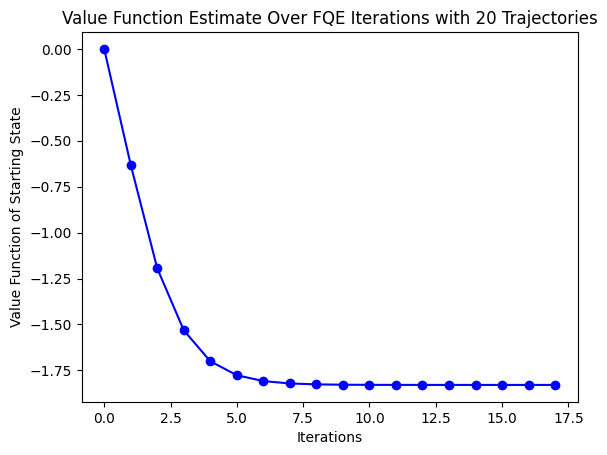

In [ ]:
# Run Fitted Q Evaluation
print("Running Fitted Q Evaluation (FQE) with 20 trajectories...")
theta_history = run_fqe(mdp, transitions)

estimated_values = [estimate_policy_value(mdp, theta) for theta in theta_history]

# Plot the mean
plt.plot(range(len(theta_history)), estimated_values, marker='o', linestyle='-', color='b')
plt.xlabel('Iterations')
plt.ylabel('Value Function of Starting State')
plt.title('Value Function Estimate Over FQE Iterations with 20 Trajectories')

# Display the plot
plt.show()


In [ ]:
print(f"Theta from iterative FQE: {theta_history[-1]}")
theta_iterative = theta_history[-1]
theta_closed, influences = run_fqe_with_influences(mdp, transitions)
print(f"Theta from closed form FQE: {theta_closed}")

Theta from iterative FQE: [-0.50600191  0.23778911  0.25840511 -0.71927991 -1.40200492 -0.41977214]
Theta from closed form FQE: [-0.46102667  0.23778915  0.25840515 -0.71927991 -1.40200492 -0.41977214]


In [ ]:
def remove_influential(transitions, influences, transition_prob):
    influences = np.abs(influences)
    indices = range(len(transitions))

    # zip and sort by influence (high to low)
    zipped_sorted = sorted(zip(transitions, influences, transition_prob, indices), key=lambda pair: -pair[1])
    sorted_transitions, sorted_influences, sorted_transition_prob, sorted_indices = zip(*zipped_sorted)

    # get top 5% influential datapoints
    num_to_remove = int(len(indices) * 0.05)
    influential_indices = sorted_indices[0:num_to_remove]

    # filter out low probability transitions
    probability_cutoff = sorted(transition_prob)[int(0.15 * len(transition_prob))]
    removed_indices = [i for i in influential_indices if transition_prob[i] <= probability_cutoff]

    # exclude from returned transitions
    return [transitions[i] for i in indices if i not in removed_indices]

In [ ]:
new_transitions = remove_influential(transitions, influences, transition_prob)
print(len(transitions))
print(len(new_transitions))

400
391


In [ ]:
indices = range(len(transitions))
abs_influences = np.abs(influences)

zipped_sorted = sorted(zip(transitions, abs_influences, indices), key=lambda pair: -pair[1])

# If you need the sorted lists back as separate lists:
sorted_transitions, sorted_abs_influences, sorted_indices = zip(*zipped_sorted)

In [ ]:
most_influential = sorted_indices[0]
transitions[most_influential]

(-2.670762691712266,
 -1.1005288975175533,
 -7.132973355442148,
 -4.245114320556079)

In [ ]:
influences[most_influential]

0.12276827394600476

Running Fitted Q Evaluation (FQE)...


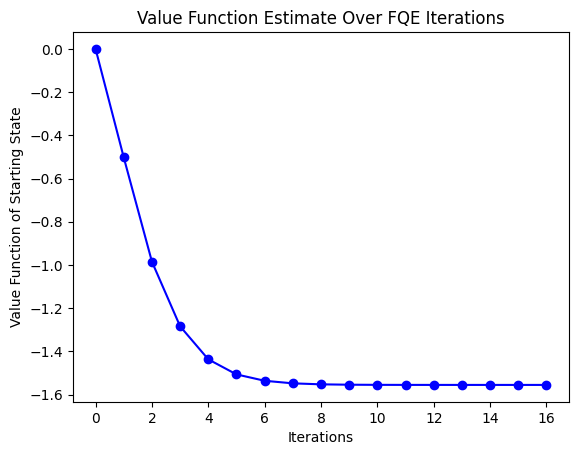

In [ ]:
# Generate data from the behavior policy
num_trajectories = 100
trajectory_length = 10
data = mdp.generate_trajectories(
    policy_function=mdp.behavior_policy,
    num_trajectories=num_trajectories,
    trajectory_length=trajectory_length,
)

# Flatten trajectories into transitions
transitions = [t for traj in data for t in traj]

# Run Fitted Q Evaluation
print("Running Fitted Q Evaluation (FQE)...")
theta_history = run_fqe(mdp, transitions)

estimated_values = [estimate_policy_value(mdp, theta) for theta in theta_history]

# Plot the mean
plt.plot(range(len(theta_history)), estimated_values, marker='o', linestyle='-', color='b')
plt.xlabel('Iterations')
plt.ylabel('Value Function of Starting State')
plt.title('Value Function Estimate Over FQE Iterations')

# Display the plot
plt.show()


In [ ]:
theta_closed, _ = run_fqe_with_influences(mdp, transitions)
estimated_values = estimate_policy_value(mdp, theta_closed)
estimated_values

-1.5056276278113665

In [ ]:
# Bootstrapping to estimate variance
def bootstrap_fqe(mdp, transitions, num_bootstrap_samples=100, num_iterations=20):
    """
    Perform bootstrapping to estimate the variance of the Q-function parameters.

    Parameters:
    - mdp: Instance of the MDP.
    - transitions: List of transitions (s, a, r, s').
    - num_bootstrap_samples: Number of bootstrap samples.
    - num_iterations: Number of iterations for FQE.

    Returns:
    - theta_samples: Array of theta estimates from each bootstrap sample.
    """

    final_theta = []
    theta_histories = []

    n_transitions = len(transitions)

    for i in range(num_bootstrap_samples):
        # Resample transitions with replacement
        indices = np.random.choice(n_transitions, size=n_transitions, replace=True)
        bootstrap_transitions = [transitions[idx] for idx in indices]

        # Run FQE on the bootstrap sample
        theta_history = run_fqe(mdp, bootstrap_transitions, num_iterations=num_iterations, break_at_converge=False)
        theta_histories.append(theta_history)
        final_theta.append(theta_history[-1])

        if (i + 1) % (num_bootstrap_samples / 10) == 0:
            print(f"Bootstrap Sample {i + 1}/{num_bootstrap_samples} completed.")

    final_theta = np.array(final_theta)
    q_values_means = []
    q_values_variances = []

    for i in range(num_iterations):
        thetas = [theta_history[i] for theta_history in theta_histories]
        # Compute Q-values for each bootstrap sample
        q_values_samples = []
        for theta in thetas:
            q_values_samples.append(estimate_policy_value(mdp, theta))

        q_values_samples = np.array(q_values_samples)

        # Compute variance of Q-values
        q_values_mean = np.mean(q_values_samples, axis=0)
        q_values_variance = np.var(q_values_samples, axis=0)

        q_values_means.append(q_values_mean)
        q_values_variances.append(q_values_variance)

        # Create the histogram
        plt.hist(q_values_samples, bins=30, edgecolor='black', alpha=0.7)

        # Add labels and title
        plt.xlabel(f"Mean: {q_values_mean}, Var: {q_values_variance}")
        plt.ylabel('Frequency')
        plt.title(f'Bootstrap iteration {i+1} value function estimates')

        # Display the plot
        plt.show()


    # Plot mean and variance over iterations
    x = range(num_iterations)

    # Plot the mean
    plt.plot(x, q_values_means, marker='o', linestyle='-', color='b')
    plt.xlabel('Iterations')
    plt.ylabel('Mean')
    plt.title('Value Function Mean Over FQE Iterations')

    # Display the plot
    plt.show()

    # Plot the mean
    plt.plot(x, q_values_variances, marker='o', linestyle='-', color='b')
    plt.xlabel('Iterations')
    plt.ylabel('Variance')
    plt.title('Value Function Variance Over FQE Iterations')

    # Display the plot
    plt.show()

    return final_theta

In [ ]:
# # Generate data from the behavior policy
# num_trajectories = 20
# trajectory_length = 20
# behavior_data = mdp.generate_trajectories(
#     policy_function=mdp.behavior_policy,
#     num_trajectories=num_trajectories,
#     trajectory_length=trajectory_length
# )

# transitions = [t for traj in behavior_data for t in traj]

# # Settings for both bootstrap
# num_bootstrap_samples = 100
# num_iterations = 20

In [ ]:
# # Perform bootstrapping on behavior data
# print("Performing bootstrapping on behavior transitions...")
# theta_samples = bootstrap_fqe(
#     mdp,
#     transitions,
#     num_bootstrap_samples=num_bootstrap_samples,
#     num_iterations=num_iterations
# )

In [ ]:
# # Add atypical transition
# s = -4
# a = mdp.evaluation_policy(s)
# atypical_transition = (s, a, mdp.reward(s, a), 4)
# atypical_transitions = transitions.copy()
# atypical_transitions.append(atypical_transition)

In [ ]:
# # Perform bootstrapping on behavior data with atypical transiton
# print("Performing bootstrapping with atypical transition...")
# theta_samples = bootstrap_fqe(
#     mdp,
#     atypical_transitions,
#     num_bootstrap_samples=num_bootstrap_samples,
#     num_iterations=num_iterations
# )

In [ ]:
# Bootstrapping to estimate variance
def bootstrap_fqe_closed(mdp, transitions, num_bootstrap_samples=100):
    """
    Perform bootstrapping to estimate the variance of the Q-function parameters.

    Parameters:
    - mdp: Instance of the MDP.
    - transitions: List of transitions (s, a, r, s').
    - num_bootstrap_samples: Number of bootstrap samples.
    - num_iterations: Number of iterations for FQE.

    Returns:
    - theta_samples: Array of theta estimates from each bootstrap sample.
    """
    n_transitions = len(transitions)
    final_theta = []
    for i in range(num_bootstrap_samples):
        # Resample transitions with replacement
        indices = np.random.choice(n_transitions, size=n_transitions, replace=True)
        bootstrap_transitions = [transitions[idx] for idx in indices]

        # Run FQE on the bootstrap sample
        theta, _ = run_fqe_with_influences(mdp, bootstrap_transitions)
        final_theta.append(theta)

        # final_theta.append(theta_history[-1])

        if (i + 1) % (num_bootstrap_samples / 10) == 0:
            print(f"Bootstrap Sample {i + 1}/{num_bootstrap_samples} completed.")

    final_theta = np.array(final_theta)
    q_values_means = []
    q_values_variances = []

    # for i in range(num_iterations):
    thetas = final_theta
    # Compute Q-values for each bootstrap sample
    q_values_samples = []
    for theta in thetas:
        q_values_samples.append(estimate_policy_value(mdp, theta))

    q_values_samples = np.array(q_values_samples)

    # Compute variance of Q-values
    q_values_mean = np.mean(q_values_samples, axis=0)
    q_values_variance = np.var(q_values_samples, axis=0)

    q_values_means.append(q_values_mean)
    q_values_variances.append(q_values_variance)

    # Create the histogram
    plt.hist(q_values_samples, bins=30, edgecolor='black', alpha=0.7)

    # Add labels and title
    plt.xlabel(f"Mean: {q_values_mean}, Var: {q_values_variance}")
    plt.ylabel('Frequency')
    plt.title(f'Bootstrap value function estimates')

    # Display the plot
    plt.show()

    return final_theta

In [ ]:
# Generate data from the behavior policy
num_trajectories = 50
trajectory_length = 50
behavior_data = mdp.generate_trajectories(
    policy_function=mdp.behavior_policy,
    num_trajectories=num_trajectories,
    trajectory_length=trajectory_length
)

transitions = [t for traj in behavior_data for t in traj]

# Settings for both bootstrap
num_bootstrap_samples = 100

Performing bootstrapping on behavior transitions...
Bootstrap Sample 10/100 completed.
Bootstrap Sample 20/100 completed.
Bootstrap Sample 30/100 completed.
Bootstrap Sample 40/100 completed.
Bootstrap Sample 50/100 completed.
Bootstrap Sample 60/100 completed.
Bootstrap Sample 70/100 completed.
Bootstrap Sample 80/100 completed.
Bootstrap Sample 90/100 completed.
Bootstrap Sample 100/100 completed.


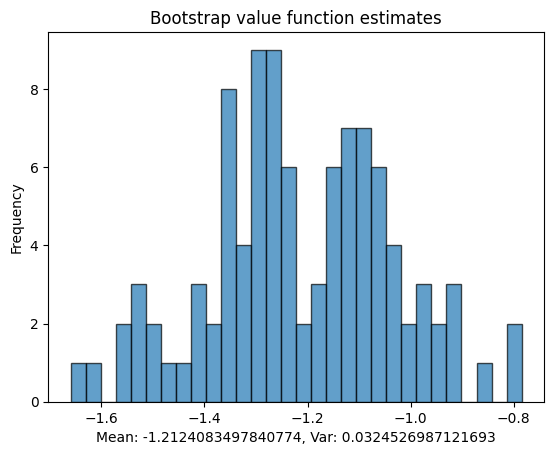

In [ ]:
# Perform bootstrapping on behavior data
print("Performing bootstrapping on behavior transitions...")
theta_samples = bootstrap_fqe_closed(
    mdp,
    transitions,
    num_bootstrap_samples=num_bootstrap_samples
)

In [ ]:
transition_prob = mdp.transition_prob(transitions)

In [ ]:
_, influences = run_fqe_with_influences(mdp, transitions)

filtered_transitions = remove_influential(transitions, influences, transition_prob)
print(len(transitions))
print(len(filtered_transitions))

2500
2448


Performing bootstrapping without low prob influential transitions...
Bootstrap Sample 10/100 completed.
Bootstrap Sample 20/100 completed.
Bootstrap Sample 30/100 completed.
Bootstrap Sample 40/100 completed.
Bootstrap Sample 50/100 completed.
Bootstrap Sample 60/100 completed.
Bootstrap Sample 70/100 completed.
Bootstrap Sample 80/100 completed.
Bootstrap Sample 90/100 completed.
Bootstrap Sample 100/100 completed.


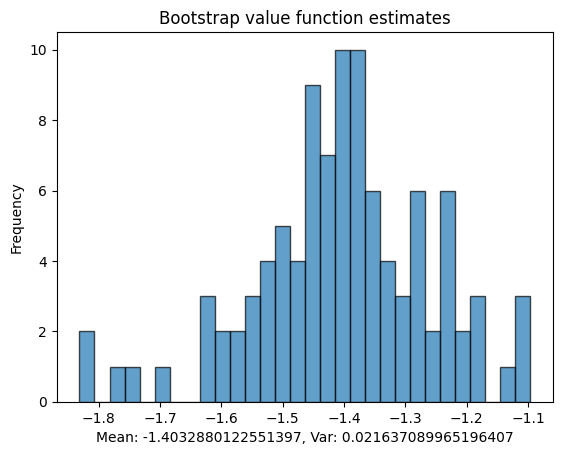

In [ ]:
# Perform bootstrapping on behavior data with atypical transiton
print("Performing bootstrapping without low prob influential transitions...")
theta_samples = bootstrap_fqe_closed(
    mdp,
    filtered_transitions,
    num_bootstrap_samples=num_bootstrap_samples
)